<a href="https://colab.research.google.com/github/AlgorithmBurv/Alzhaimer-Detection/blob/main/Alzhaimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar Bahan Makanan

## Menyiapkan Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib



In [ ]:
# !pip install -q opendatasets

# import opendatasets as od
# import pandas as pd

# od.download('https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset') # insert ypu kaggle

## Preprocessing Data

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (256, 256)

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/alzheimer-mri-dataset/Dataset",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

Found 6400 files belonging to 4 classes.


In [ ]:
train_size = 0.8
len(dataset)*train_size

80.0

In [ ]:
train_size = 0.8
len(dataset)*train_size

80.0

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(f"Train size: {len(train_ds)} \nTest size: {len(test_ds)} \nVal size: {len(val_ds)}")

Train size: 80 
Test size: 10 
Val size: 10


## Membuat Model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 60, 60, 32)       

## Melatih Model

In [ ]:

from tensorflow.keras.callbacks import Callback

class AccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96:
            print("\nAkurasi dan validasi melebihi 96%, menghentikan pelatihan.")
            self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [ ]:
import time
start = time.time()


num_epochs = 10

H = model.fit(
              train_ds,
              batch_size=BATCH_SIZE,
              validation_data=val_ds,
              verbose=1,
              epochs=num_epochs,
              callbacks=[accuracy_callback]
              )

stop = time.time()
print(f"Training time: {round((stop - start)/60)} minute")


Epoch 1/10
 6/80 [=>............................] - ETA: 7s - loss: 1.3901 - accuracy: 0.3880

80/80 [==============================] - 23s 179ms/step - loss: 1.0303 - accuracy: 0.5154 - val_loss: 0.8627 - val_accuracy: 0.6094
Epoch 2/10
80/80 [==============================] - 23s 211ms/step - loss: 0.8591 - accuracy: 0.6148 - val_loss: 0.7565 - val_accuracy: 0.6703
Epoch 3/10
80/80 [==============================] - 24s 210ms/step - loss: 0.6272 - accuracy: 0.7324 - val_loss: 0.4283 - val_accuracy: 0.8469
Epoch 4/10
80/80 [==============================] - 23s 212ms/step - loss: 0.4068 - accuracy: 0.8375 - val_loss: 0.2372 - val_accuracy: 0.9234
Epoch 5/10
80/80 [==============================] - 23s 213ms/step - loss: 0.2510 - accuracy: 0.9004 - val_loss: 0.1816 - val_accuracy: 0.9344
Epoch 6/10
80/80 [==============================] - 21s 178ms/step - loss: 0.1524 - accuracy: 0.9424 - val_loss: 0.0676 - val_accuracy: 0.9828
Epoch 7/10
80/80 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9664
Akurasi dan validasi melebihi 96%, menghentikan pelatihan.


# Evaluation

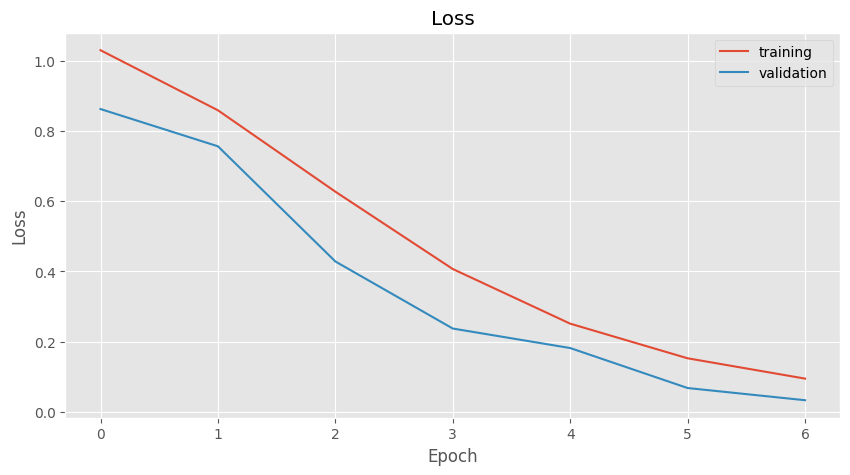

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
epochs = np.arange(0, len(H.history["loss"]))
plt.plot(epochs, H.history["loss"], label="training")
plt.plot(epochs, H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


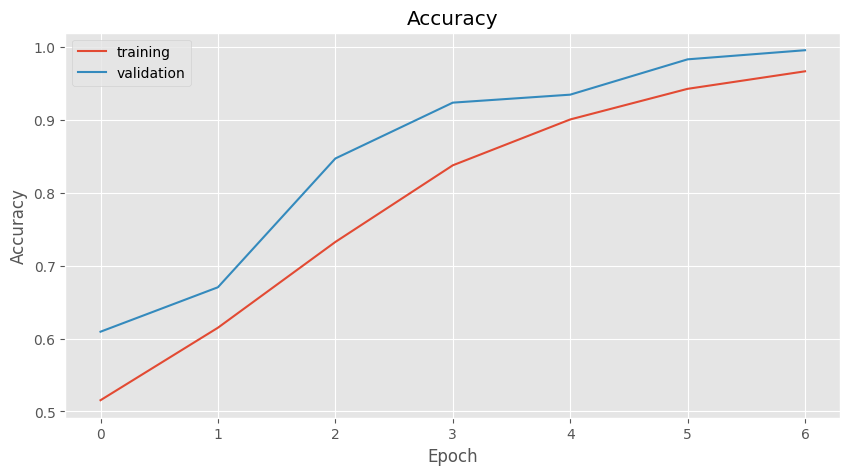

In [ ]:
plt.figure(figsize=(10, 5))
epochs = np.arange(0, len(H.history["accuracy"]))
plt.plot(epochs, H.history["accuracy"], label="training")
plt.plot(epochs, H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
